# Evaluation

In this notebook we will demonstrate how to evaluate a set of generated mixes via objective metrics.

We will use the mixes generated from the [inference notebook](https://github.com/csteinmetz1/automix-toolkit/blob/main/notebooks/inference.ipynb), and we will objectively compare those mixes to the human-made groudn truth mixes.

The objective evaluation of mixes can be carried out through audio features that relate to the most common audio effects used during mixing. Since audio effects generally manipulate audio characteristics such as frequency content, dynamics, spatialization, timbre, or pitch, we can use audio features that are associated with these audio characteristics as a way to numerically evaluate mixes.

We can use the following audio features:
    
-**Spectral features** for EQ and reverberation: centroid, bandwidth, contrast, flatness, and roll-off

-**Spatialisation features** for panning: the Panning Root Mean Square (RMS)

-**Dynamic features** for dynamic range processors: RMS level, dynamic spread and crest factor

-**Loudness features**: the integrated loudness level (LUFS) and peak loudness

To capture the dynamics of audio effects information we can compute the running mean over a fixed number of past frames. We can calculate the mean absolute percentage error (MAPE) between the target and output features to get a better understanding of the overall relative error.

Note: This notebook assumes that you have already installed the `automix` package. 

In [2]:
!pip install git+https://github.com/csteinmetz1/automix-toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/csteinmetz1/automix-toolkit to /tmp/pip-req-build-vm6pmjd1
  Running command git clone -q https://github.com/csteinmetz1/automix-toolkit /tmp/pip-req-build-vm6pmjd1


In [3]:
import os
import glob
import torchaudio
import numpy as np

import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

from automix.evaluation.utils_evaluation import get_features

# Drums mixing evaluation

We will evaluate two different trained models with a test sample from the ENST-drums subset.

Models: the Differentiable Mixing Console (DMC), and the MixWaveUNet.

In [4]:
# then download and extract a drum multitrack from the test set
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
!unzip -o drums-test-rock.zip

mix_target_path = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks.wav"
mix_auto_path_wun = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_MixWaveUNet.wav"
mix_auto_path_dmc = "drums-test-rock/mix/dry_mix_066_phrase_rock_complex_fast_sticks_DMC.wav"

# Global Settings
SR = 44100
max_samples = 262144
start_sample = 0 * SR
end_sample = start_sample + max_samples

--2022-12-03 08:04:13--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
Resolving huggingface.co (huggingface.co)... 54.147.99.175, 3.234.187.147, 2600:1f18:147f:e850:d78f:7d9d:6ec3:2aee, ...
Connecting to huggingface.co (huggingface.co)|54.147.99.175|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/78590471160237edbabf64fc347697793a647ed287bcff367bfa577753e93b70?response-content-disposition=attachment%3B%20filename%3D%22drums-test-rock.zip%22&Expires=1670313854&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2VjL2VlL2VjZWUzOGRmMDQ3ZTNmMmRiMWJkOGMzMWE3NDJmM2EwOGY1NTc0NzBjZDY3Y2I0ODc0MDJhOWMzZWQ5MWI1ZWEvNzg1OTA0NzExNjAyMzdlZGJhYmY2NGZjMzQ3Njk3NzkzYTY0N2VkMjg3YmNmZjM2N2JmYTU3Nzc1M2U5M2I3MD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPWF0dGFjaG1lbnQlM0IlMjBmaWxlbmFtZSUzRCUyMmRydW1

## Load the mixes

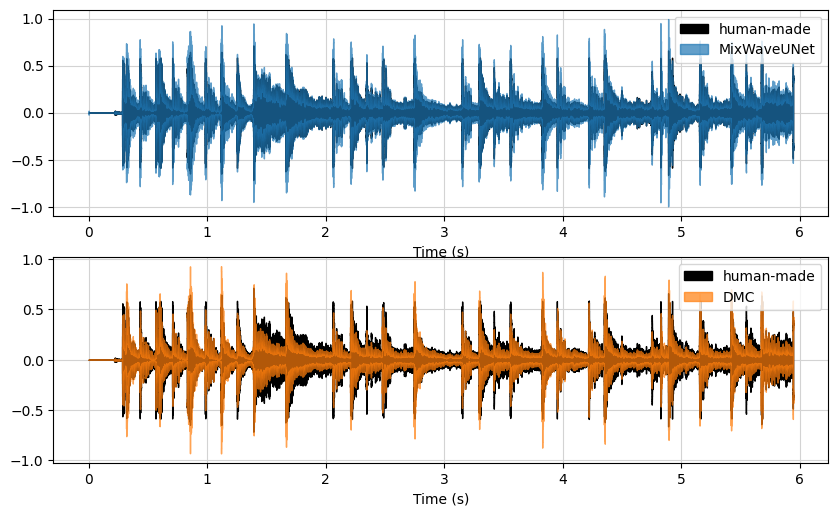

In [5]:
fig, axs = plt.subplots(2, 1)

target_audio, sr = torchaudio.load(mix_target_path)
target_audio = target_audio[:, start_sample: end_sample]

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[0])

wun_audio, sr = torchaudio.load(mix_auto_path_wun)
wun_audio = wun_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    wun_audio[0,:].view(-1).numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='MixWaveUNet', 
    color='tab:blue', 
    ax=axs[0], alpha=0.7)
axs[0].grid(c="lightgray")
axs[0].legend()

librosa.display.waveshow(
    target_audio[0,:].numpy(), 
    x_axis='s', 
    sr=SR, 
    zorder=3, 
    label='human-made', 
    color='k', 
    ax=axs[1])

dmc_audio, sr = torchaudio.load(mix_auto_path_dmc)
dmc_audio = dmc_audio[:, start_sample: end_sample]
librosa.display.waveshow(
    dmc_audio[0,:].view(-1).numpy(),
    x_axis='s',
    sr=SR,
    zorder=3,
    label='DMC', 
    color='tab:orange', 
    ax=axs[1], 
    alpha=0.7)
axs[1].grid(c="lightgray")
axs[1].legend()

## Compute the loudness, spectral, panning and dynamic features

In [6]:
target_audio = target_audio.numpy()
wun_audio = wun_audio.numpy()
dmc_audio = dmc_audio.numpy()

wun_features = get_features(target_audio, wun_audio)
dmc_features = get_features(target_audio, dmc_audio)

/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/librosa/util/utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


In [7]:
print('Mix Wave-U-Net - mean absolute percentage error per feature: ')
for k, i in wun_features.items():
    print(k, i)   

Mix Wave-U-Net - mean absolute percentage error per feature: 
lufs_loudness 0.10304796666518391
peak_loudness 0.6153269159862367
mean_mape_loudness 0.3591874413257103
centroid 0.07771542129844329
bandwidth 0.02074449515873549
contrast_lows 0.03402423596487594
contrast_mids 0.021213729113018307
contrast_highs 0.020418530820661373
rolloff 0.056812596999243334
flatness 0.21573982
mean_mape_spectral 0.06380983225460123
panning_rms_total 0.05961496384304375
panning_rms_lows 0.11983733716557873
panning_rms_mids 0.07513031358751145
panning_rms_highs 0.0574753023115106
mean_mape_panning 0.07801447922691113
rms_level 0.03705513649501611
dynamic_spread 0.034629700876661895
crest_factor 0.059185002409598134
mean_mape_dynamic 0.04362327992709205


In [8]:
print('Mix DMC - mean absolute percentage error per feature: ')
for k, i in dmc_features.items():
    print(k, i)

Mix DMC - mean absolute percentage error per feature: 
lufs_loudness 0.05079889059714656
peak_loudness 0.31816527664650845
mean_mape_loudness 0.1844820836218275
centroid 0.1615137813187354
bandwidth 0.0369705944258171
contrast_lows 0.0534443574161947
contrast_mids 0.014752917999981133
contrast_highs 0.04878563928670107
rolloff 0.11574088885944224
flatness 0.33274597
mean_mape_spectral 0.10913630694319619
panning_rms_total 0.12243039715427145
panning_rms_lows 0.04014840181011064
panning_rms_mids 0.03167409177923675
panning_rms_highs 0.13560620241244903
mean_mape_panning 0.08246477328901697
rms_level 0.19143726340696104
dynamic_spread 0.08219802568137809
crest_factor 0.2542721558061214
mean_mape_dynamic 0.1759691482981535


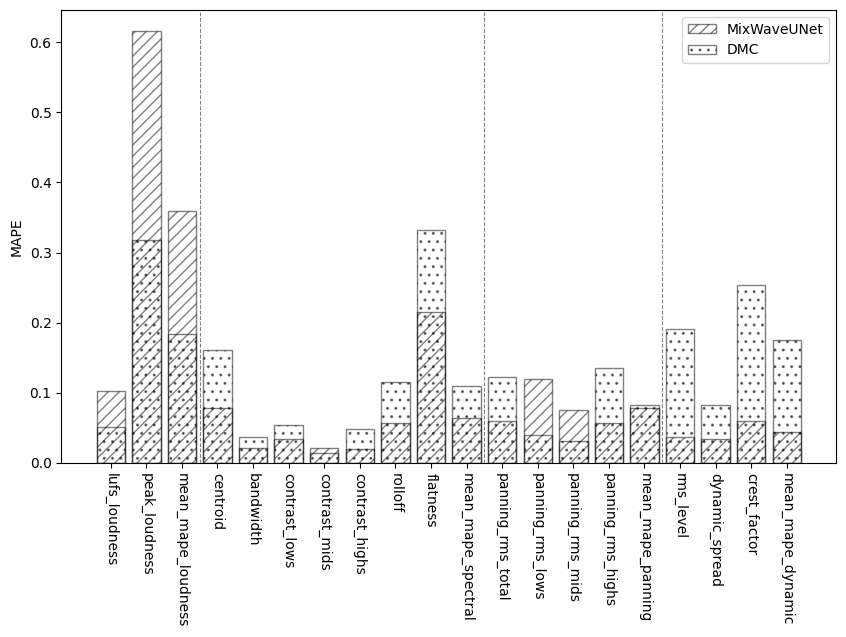

In [9]:
plt.bar(*zip(*wun_features.items()), alpha=0.5, fill=False, hatch='///', label='MixWaveUNet')
plt.bar(*zip(*dmc_features.items()), alpha=0.5,fill=False, hatch='..', label='DMC')
plt.axvline(2.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(10.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.axvline(15.5, 0, 1, linestyle='--', alpha=0.5, color='k', linewidth=0.75)
plt.xticks(rotation=-90)
plt.ylabel('MAPE')
plt.legend()
plt.show()